In [3]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error


In [4]:
data = pd.read_excel("/content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


(220, 4)


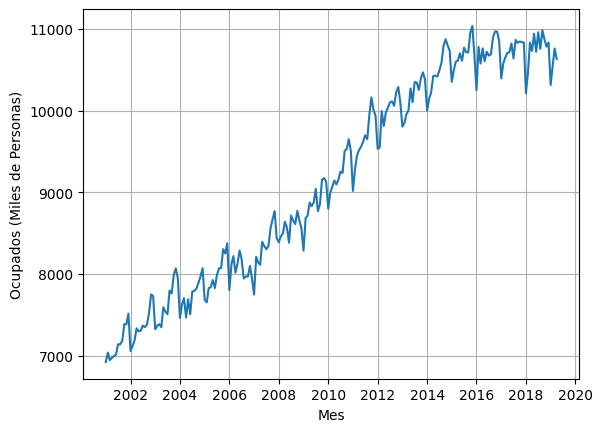

In [5]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("")
plt.xlabel("Mes")
plt.ylabel("Ocupados (Miles de Personas)")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

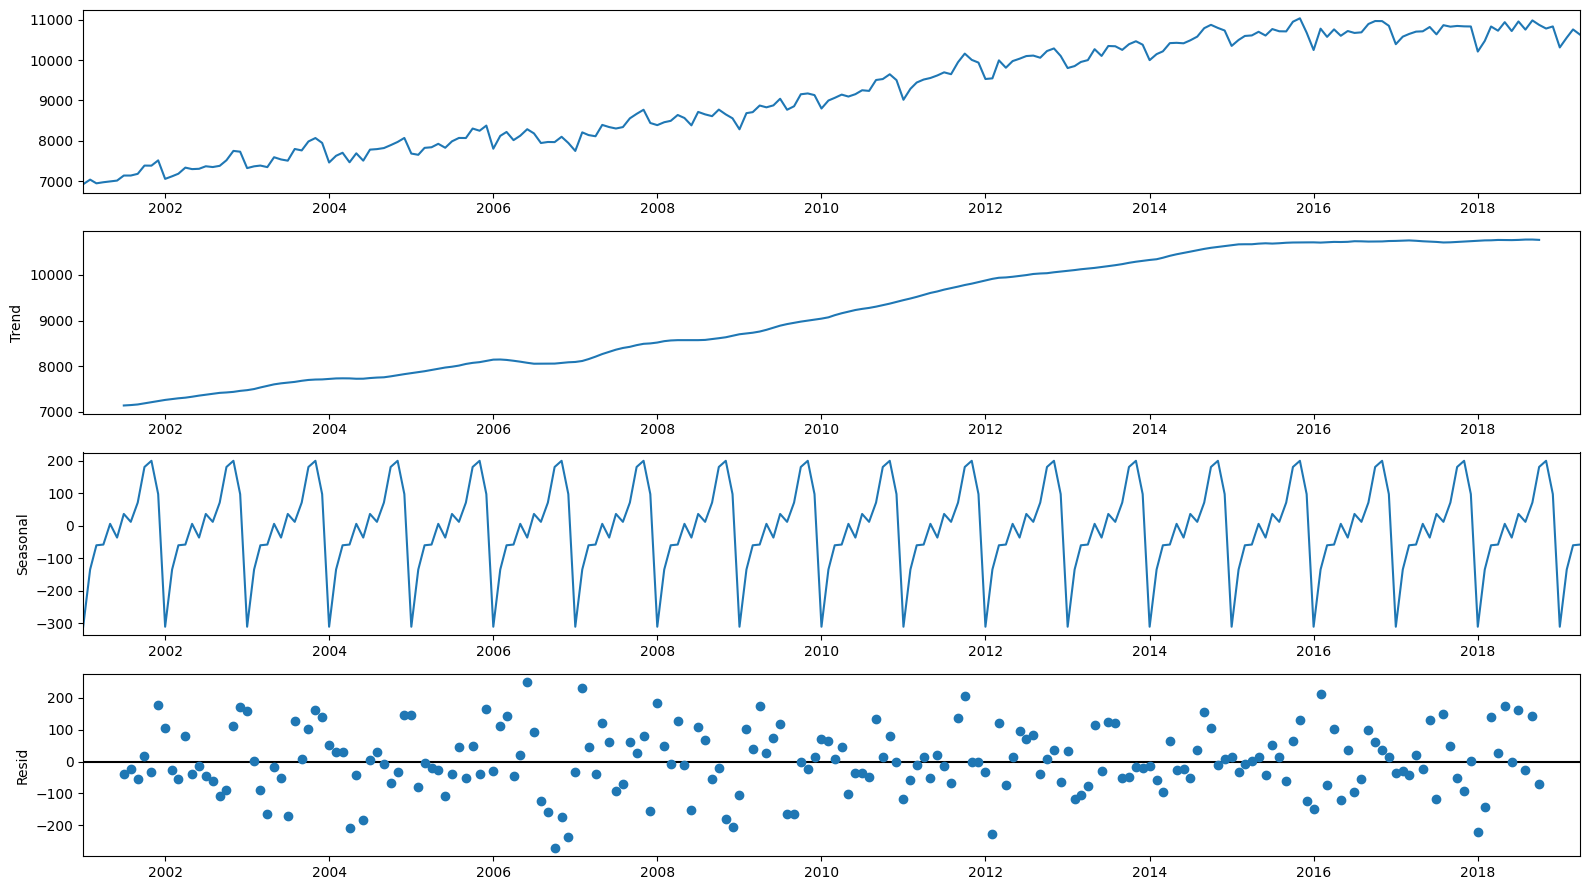

In [6]:
td_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

In [7]:
td_componentes.seasonal
#td_componentes.trend
#td_componentes.resid

mes
2001-01-01   -311.454885
2001-02-01   -135.216366
2001-03-01    -60.470657
2001-04-01    -58.270721
2001-05-01      5.551095
                 ...    
2018-12-01     97.140345
2019-01-01   -311.454885
2019-02-01   -135.216366
2019-03-01    -60.470657
2019-04-01    -58.270721
Name: seasonal, Length: 220, dtype: float64

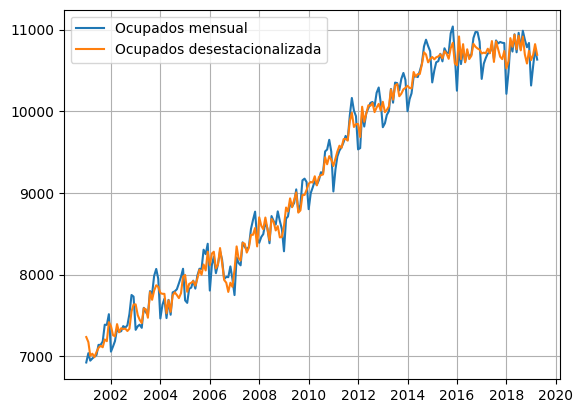

In [8]:
td_desestacionalizada = data["Ocupados"]-td_componentes.seasonal

plt.plot(data[["Ocupados"]],label="Ocupados mensual")
plt.plot(td_desestacionalizada,label="Ocupados desestacionalizada")
plt.legend()
plt.grid()
plt.show()


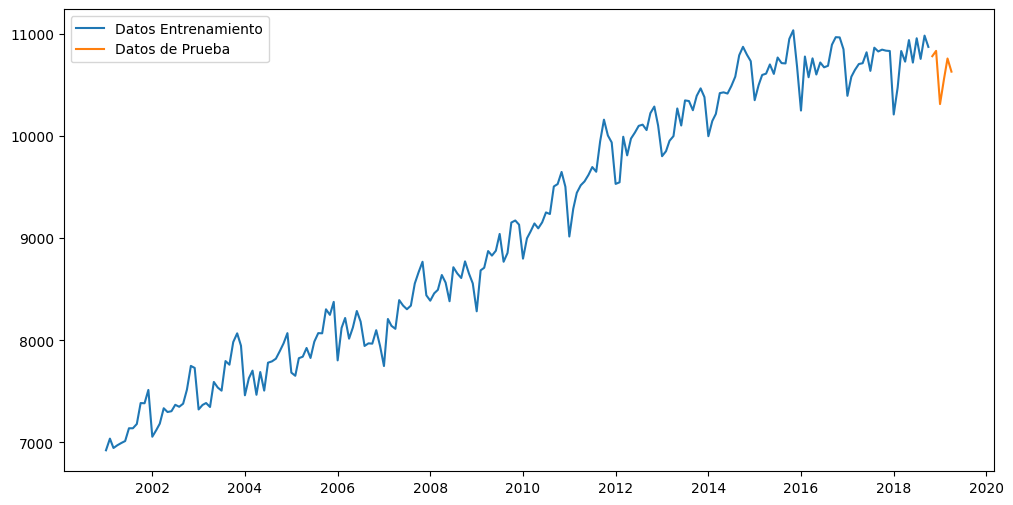

In [9]:
train_len = 214
train_oc = data[["Ocupados"]][:train_len]
test_oc = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_oc,label="Datos Entrenamiento")
plt.plot(test_oc,label="Datos de Prueba")
plt.legend()
plt.show()



In [10]:
#train_oc
test_oc

,Ocupados
mes,
2018-11-01,10783.299
2018-12-01,10835.398
2019-01-01,10314.438
2019-02-01,10557.917
2019-03-01,10760.776
2019-04-01,10632.028


In [11]:
## Considerando el dato actual
ma_2= train_oc.rolling(2,min_periods=2).mean()
ma_3= train_oc.rolling(3,min_periods=2).mean()
ma_4= train_oc.rolling(4,min_periods=2).mean()
ma_5= train_oc.rolling(5,min_periods=2).mean()

In [12]:
## Sin considerar el dato actual
ma_2= train_oc.shift().rolling(2,min_periods=2).mean()
ma_3= train_oc.shift().rolling(3,min_periods=2).mean()
ma_4= train_oc.shift().rolling(4,min_periods=2).mean()
ma_5= train_oc.shift().rolling(5,min_periods=2).mean()

In [13]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [14]:
ma_2_f= fore_ma(train_oc,2,6)
ma_3_f= fore_ma(train_oc,3,6)
ma_4_f= fore_ma(train_oc,4,6)
ma_5_f= fore_ma(train_oc,5,6)



In [15]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_oc,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_oc,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_oc,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_oc,ma_5_f ))

print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

319.1849777906289 298.3770292088787 305.34686253059 291.01606293356485


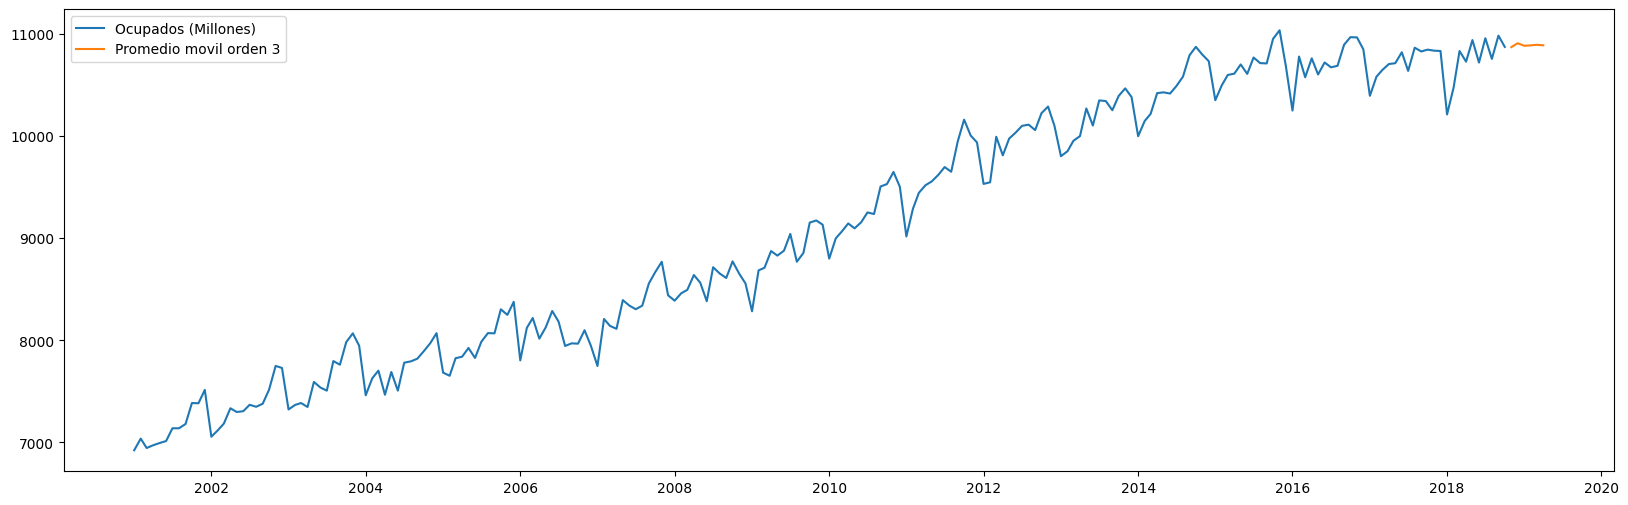

In [16]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_oc,label="Ocupados (Millones)")
plt.plot(ma_3_f,label="Promedio movil orden 3")
plt.legend()
plt.show()

### **4.2 Suavizacion Exponencial Simple**

In [17]:
# Build model.
ets_model = ETSModel(endog=train_oc["Ocupados"],error="add")#,trend="add",seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10890.815856  10535.182689  11246.449022
2018-12-01    10890.815856  10469.673459  11311.958252
2019-01-01    10890.815856  10413.063946  11368.567765
2019-02-01    10890.815856  10362.485602  11419.146109
2019-03-01    10890.815856  10316.343206  11465.288506
2019-04-01    10890.815856  10273.641006  11507.990705


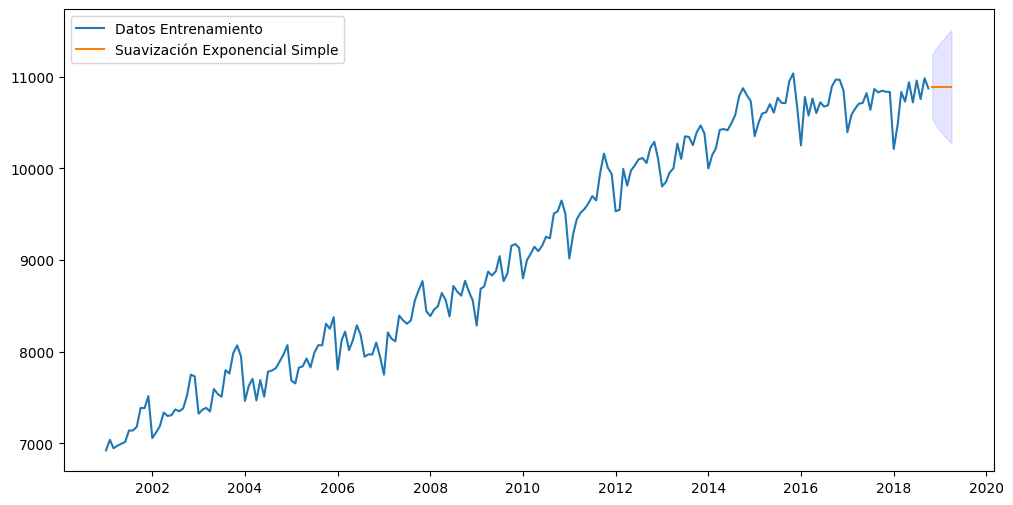

In [18]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_oc,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

In [19]:
ets_result.alpha

0.6343030045478203

In [20]:
rmse = np.sqrt(mean_squared_error(test_oc,point_forecast))
print(rmse)

300.4290298412983


### **4.3 Suavizacion Exponencial Lineal (Holt)**

In [21]:
# Build model.
ets_model = ETSModel(endog=train_oc["Ocupados"],error="add",trend="add")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hold = pd.concat([limits, conf_forecast], axis = 1)
preds_hold.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10890.815856  10535.182689  11246.449022
2018-12-01    10890.815856  10469.673459  11311.958252
2019-01-01    10890.815856  10413.063946  11368.567765
2019-02-01    10890.815856  10362.485602  11419.146109
2019-03-01    10890.815856  10316.343206  11465.288506
2019-04-01    10890.815856  10273.641006  11507.990705


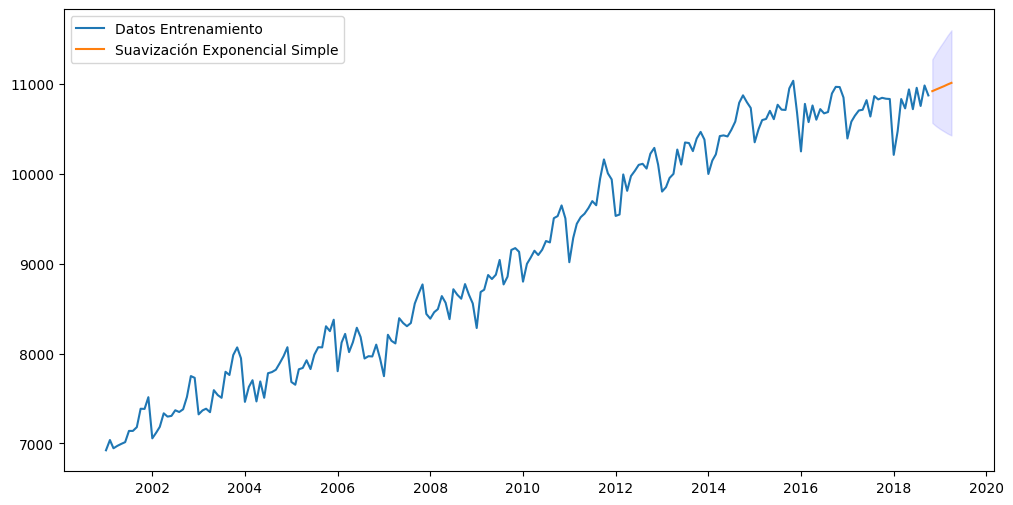

In [22]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_oc,label="Datos Entrenamiento")
plt.plot(preds_hold['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds_hold.index ,preds_hold['lower_95'], preds_hold['upper_95'],
                 color='blue', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

In [23]:
print(ets_result.alpha,ets_result.beta)

0.571963780298305 0.006149418787101443


In [24]:
rmse_holt = np.sqrt(mean_squared_error(test_oc,preds_hold['Point_forecast']))
print(rmse_holt)

370.1579750635174


## **4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [25]:
ets_model = ETSModel(endog=train_oc["Ocupados"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11016.615370  10758.765337  11274.465403
2018-12-01    10910.345328  10638.016873  11182.673784
2019-01-01    10431.804223  10145.726486  10717.881959
2019-02-01    10707.064097  10407.865684  11006.262509
2019-03-01    10853.107263  10541.337405  11164.877121
2019-04-01    10868.686776  10544.830737  11192.542816


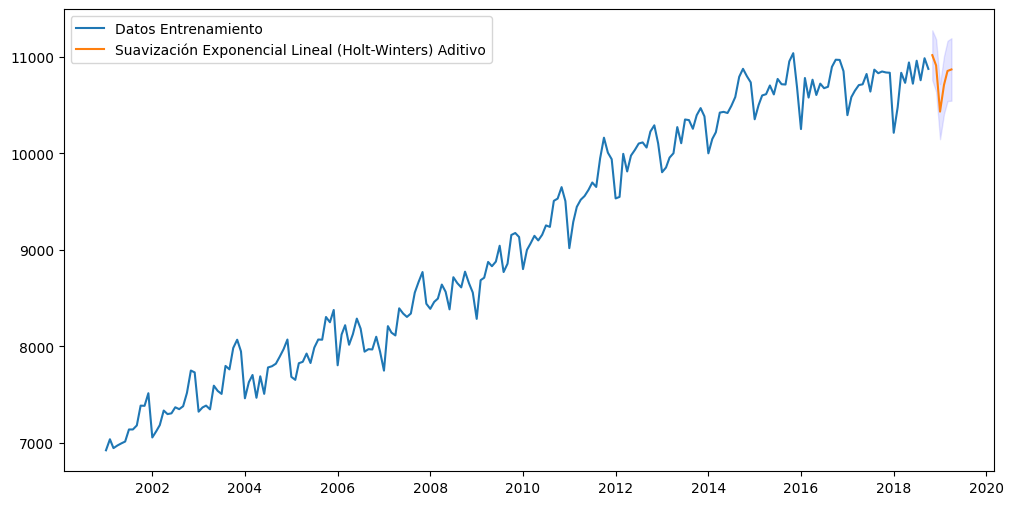

In [26]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_oc,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

In [27]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.3397512482944894 3.397512482944894e-05 0.3013646393190514


In [28]:
rmse_hw_add = np.sqrt(mean_squared_error(test_oc,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

163.6081475588887


In [29]:
# Build model.
ets_model = ETSModel(endog=train_oc["Ocupados"],error="add",trend=None,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10974.856321  10739.666266  11198.859937
2018-12-01    10849.851832  10582.319561  11106.364361
2019-01-01    10377.100978  10098.236820  10669.308343
2019-02-01    10579.686260  10232.590138  10901.620880
2019-03-01    10663.322195  10296.170393  11031.844427
2019-04-01    10672.646077  10286.779728  11026.789709


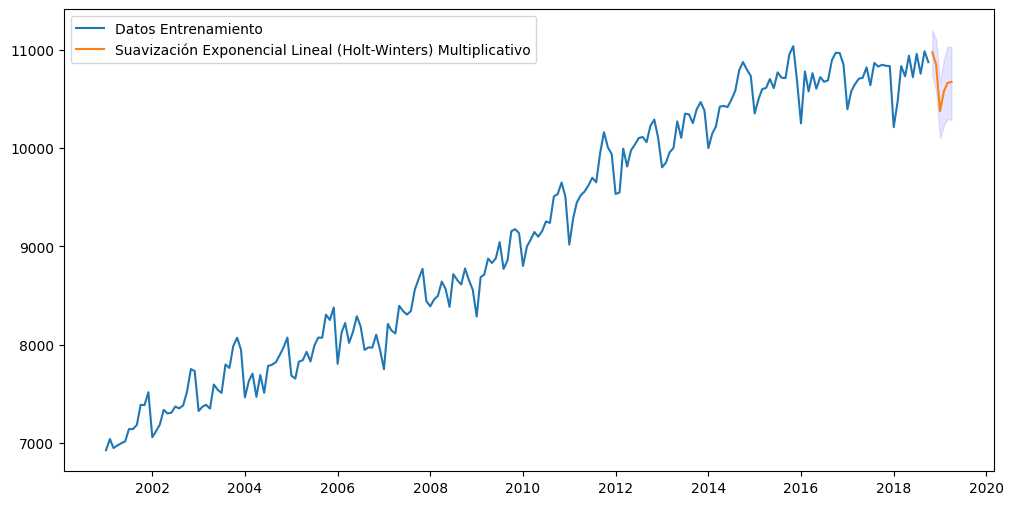

In [30]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_oc,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [31]:
print(ets_result.alpha,ets_result.gamma)

0.5955123888201141 4.0448761117988584e-05


In [32]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_oc,preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

93.49754216989305


In [33]:
df = pd.concat([train_oc, test_oc])

In [34]:
df

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2018-12-01,10835.398
2019-01-01,10314.438
2019-02-01,10557.917


In [35]:
# Build model.
ets_model = ETSModel(endog=df["Ocupados"],error="add",trend=None,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2019-05-01    10734.546130  10505.208972  10942.759913
2019-06-01    10690.119841  10412.483487  10955.073853
2019-07-01    10777.689962  10463.927299  11073.818371
2019-08-01    10748.314893  10412.282750  11061.832425
2019-09-01    10823.097462  10464.180106  11144.653310
2019-10-01    10946.540416  10588.839143  11317.216981


In [36]:
preds_hw_mul

,Point_forecast,lower_95,upper_95
2019-05-01,10734.546130,10505.208972,10942.759913
2019-06-01,10690.119841,10412.483487,10955.073853
2019-07-01,10777.689962,10463.927299,11073.818371
2019-08-01,10748.314893,10412.282750,11061.832425
2019-09-01,10823.097462,10464.180106,11144.653310
2019-10-01,10946.540416,10588.839143,11317.216981


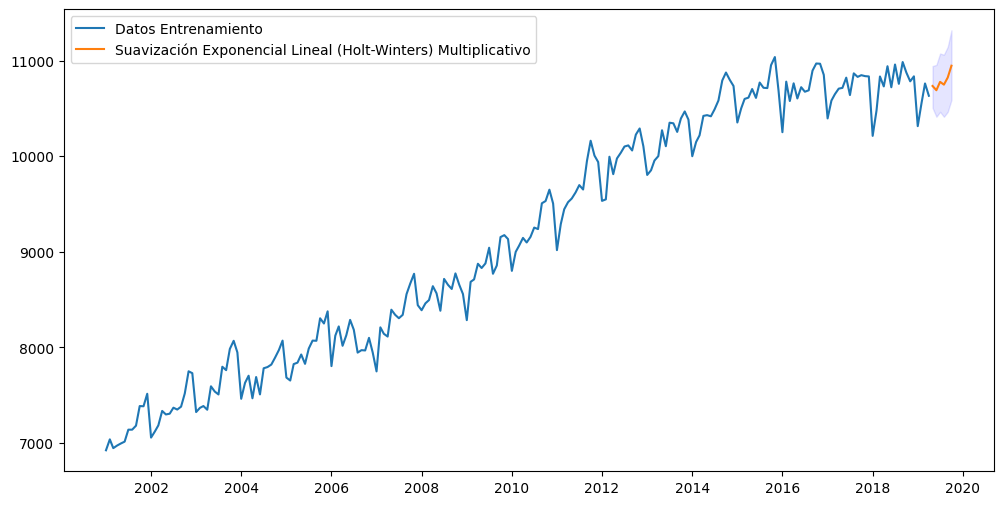

In [37]:
fig = plt.figure(figsize=(12, 6))
plt.plot(df,label="Data")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


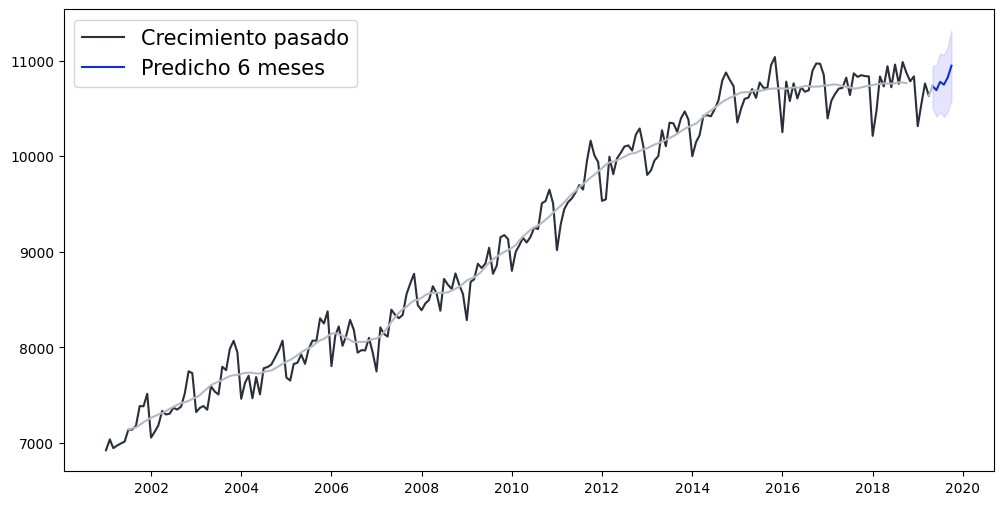

In [51]:
last_df_x = df.index[-1]
last_df_y = df.iloc[-1]
first_preds_x = preds_hw_mul.index[0]
first_preds_y = preds_hw_mul['Point_forecast'].iloc[0]

fig = plt.figure(figsize=(12, 6))
plt.plot(df,label="Crecimiento pasado", color='#2B2E3B')
plt.plot(preds_hw_mul['Point_forecast'],
         label="Predicho 6 meses", color='#0D2FD8')
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.plot([last_df_x, first_preds_x], [last_df_y, first_preds_y], color='#B7B8C1', linestyle='-')

plt.legend(fontsize=15)

plt.plot(td_componentes.trend, color='#B7B8C1', label="Tendencia")

plt.savefig('First_graph.png', dpi=300, transparent=True)



plt.show()



/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


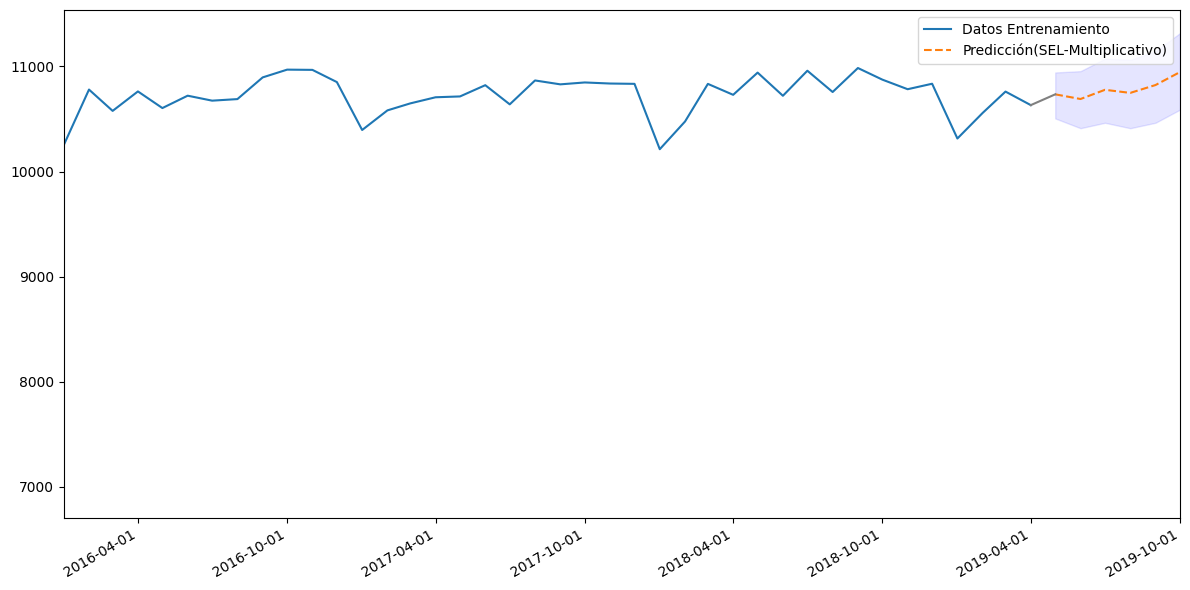

In [41]:

import matplotlib.dates as mdates

fig = plt.figure(figsize=(12, 6))
plt.plot(df, label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],
         linestyle='--',
         label="Predicción(SEL-Multiplicativo)")
plt.fill_between(preds_hw_mul.index, preds_hw_mul['lower_95'],
                 preds_hw_mul['upper_95'], color='blue', alpha=0.1)

# Ajusta el rango del eje x para mostrar datos desde 2016 hasta 2020
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2020-12-31')
plt.xlim(start_date, preds_hw_mul.index[-1])

# Ajusta el localizador de fechas para mostrar marcas cada 6 meses
months_locator = mdates.MonthLocator(bymonthday=1, interval=6)
date_format = mdates.DateFormatter('%Y-%m-%d')

plt.gca().xaxis.set_major_locator(months_locator)
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate()
plt.plot([last_df_x, first_preds_x], [last_df_y, first_preds_y], color='gray', linestyle='-')
plt.legend()
plt.tight_layout()  # Ajusta el diseño para evitar recortes
plt.show()


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
<ipython-input-60-5adc5e4d0f70>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Ajusta el diseño para evitar recortes


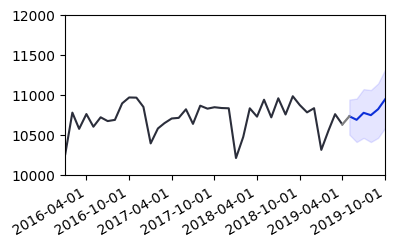

In [60]:


fig = plt.figure(figsize=(8, 4))  # Tamaño más pequeño
ax = fig.add_axes([0.55, 0.15, 0.4, 0.4])  # [left, bottom, width, height]

plt.plot(df,label="Crecimiento pasado", color='#2B2E3B')
plt.plot(preds_hw_mul['Point_forecast'],
         label="Predicho 6 meses", color='#0D2FD8')
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.plot([last_df_x, first_preds_x], [last_df_y, first_preds_y], color='#B7B8C1', linestyle='-')



# Ajusta el rango del eje x para mostrar datos desde 2016 hasta 2020
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2020-12-31')
ax.set_xlim(start_date, preds_hw_mul.index[-1])

# Ajusta el localizador de fechas para mostrar marcas cada 6 meses
months_locator = mdates.MonthLocator(bymonthday=1, interval=6)
date_format = mdates.DateFormatter('%Y-%m-%d')

plt.plot([last_df_x, first_preds_x], [last_df_y, first_preds_y], color='gray', linestyle='-')

ax.set_ylim(10000, 12000)
ax.xaxis.set_major_locator(months_locator)
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

plt.savefig('second_Zoom.png', dpi=300, transparent=True)

plt.tight_layout()  # Ajusta el diseño para evitar recortes
plt.show()
